<a href="https://www.kaggle.com/code/tct221212/nhom-5?scriptVersionId=184506195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/traffic-prediction-dataset/traffic.csv


In [2]:
traffic_data=pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

traffic_data.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
print('before dropping ',traffic_data.shape[0])
traffic_data.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',traffic_data.shape[0])

before dropping  48120
after dropping  48120


In [4]:
if(traffic_data.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    traffic_data.fillna(method='ffill',inplace=True)

no missing values in train


In [5]:
print('before converting :',traffic_data['DateTime'].dtype)
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

before converting : object


In [6]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [7]:
# Exploring more features  
traffic_data["Year"]= traffic_data['DateTime'].dt.year  
traffic_data["Month"]= traffic_data['DateTime'].dt.month  
traffic_data["Date_no"]= traffic_data['DateTime'].dt.day  
traffic_data["Hour"]= traffic_data['DateTime'].dt.hour  
#traffic_data["Day"]= traffic_data.DateTime.dt.strftime("%A")

In [8]:
traffic_data.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4


Text(0.5, 0, 'DateTime')

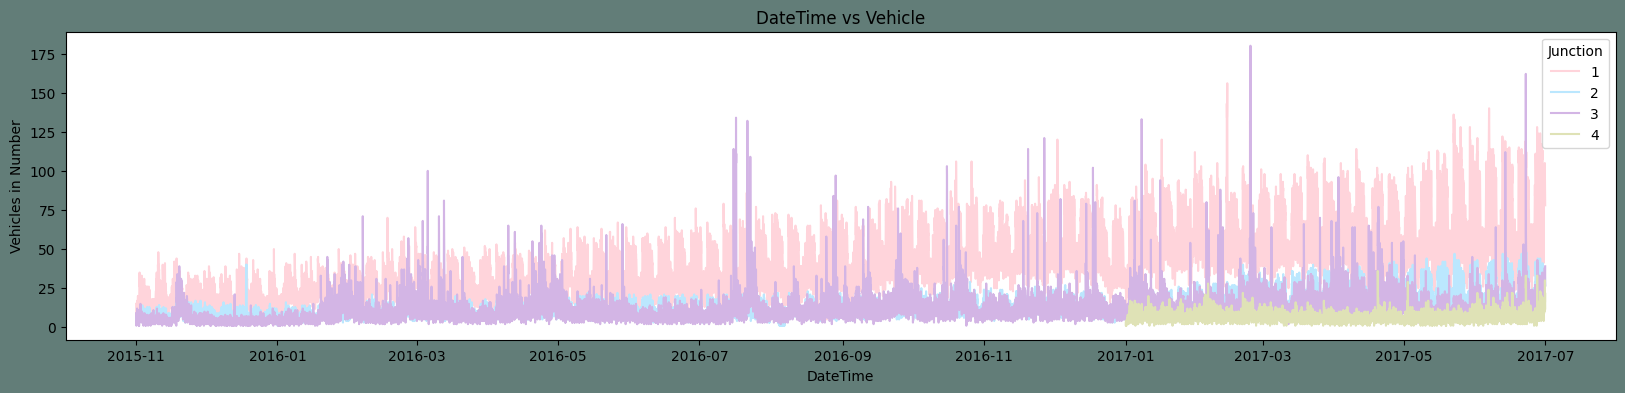

In [9]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=traffic_data['DateTime'],y="Vehicles",data=traffic_data, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime")

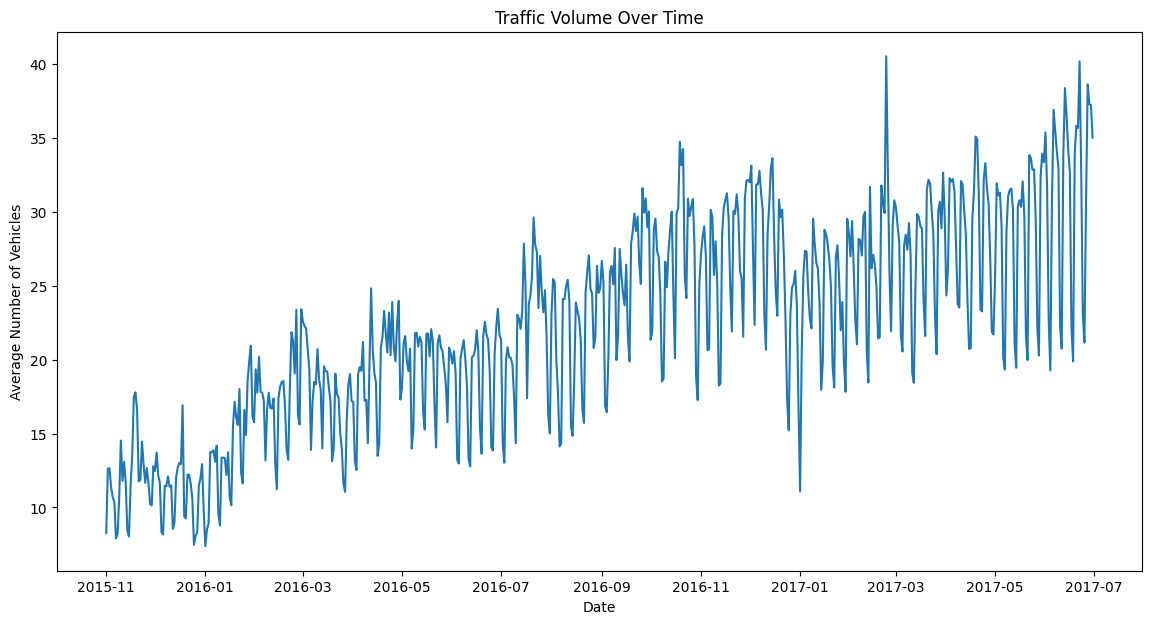

In [10]:
plt.figure(figsize=(14, 7))
traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()
sns.lineplot(data=traffic_data_resampled, x=traffic_data_resampled.index, y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.show()

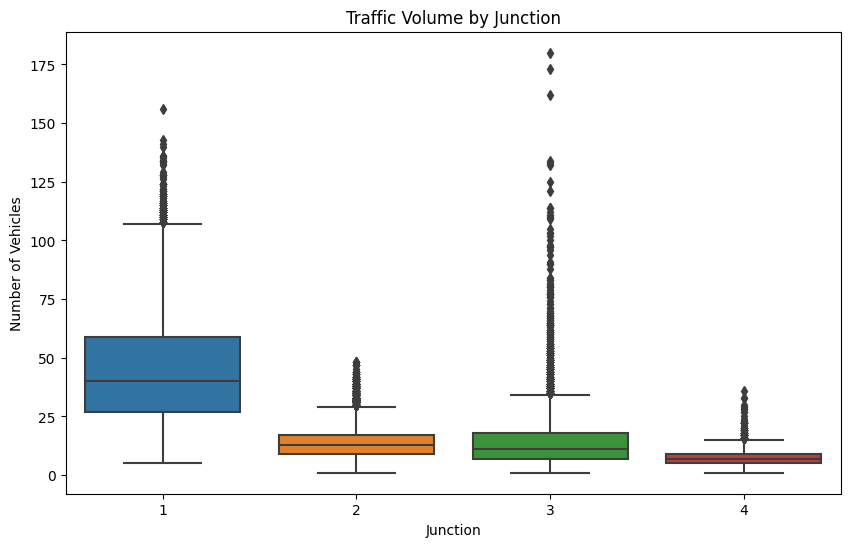

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=traffic_data)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

In [12]:

traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.day_name()

In [13]:
# Aggregate data to find mean traffic volume for each hour of the day

hourly_traffic = traffic_data.groupby('HourOfDay')['Vehicles'].mean().reset_index()

# Aggregate data to find mean traffic volume for each day of the week

weekly_traffic = traffic_data.groupby('DayOfWeek')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

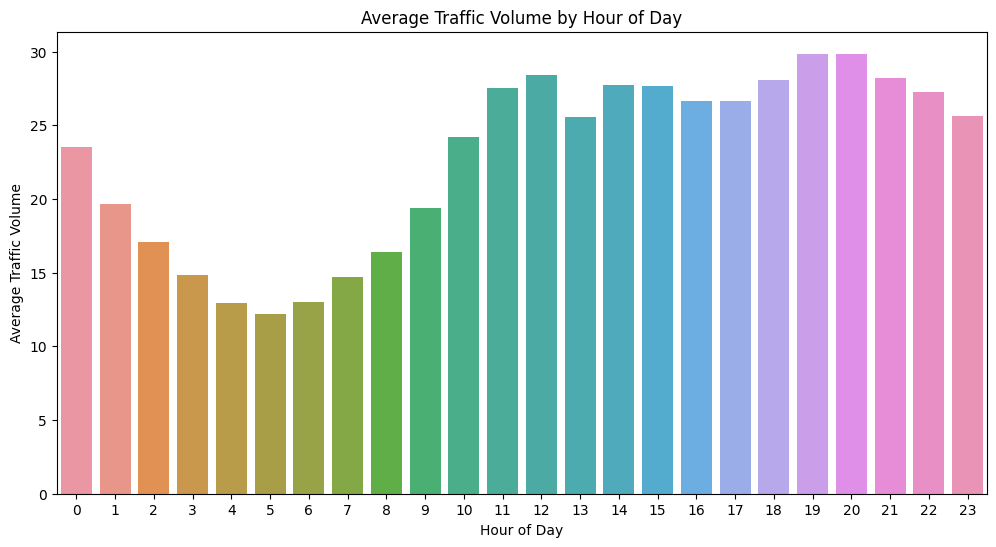

In [14]:
# Plotting the hourly traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='HourOfDay', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

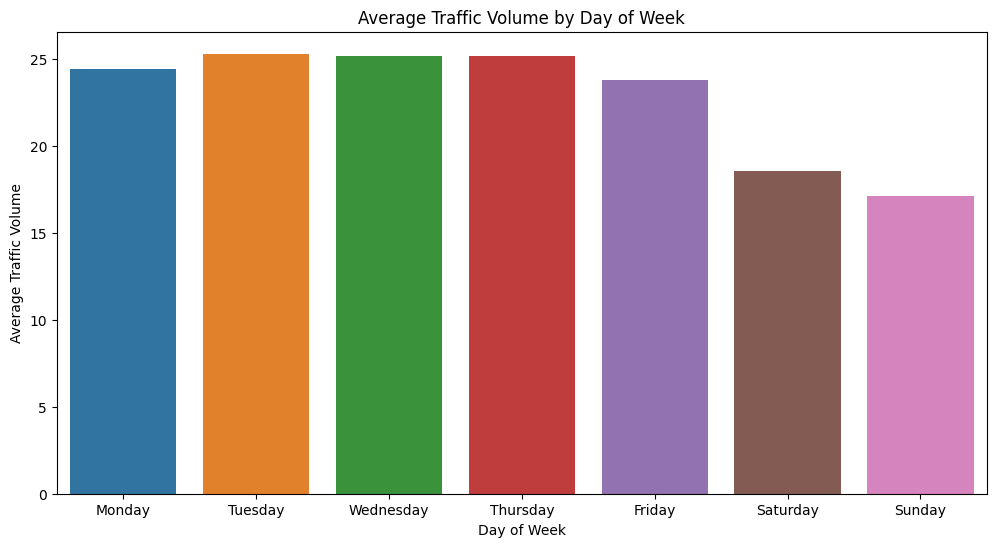

In [15]:
# Plotting the daily traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='Vehicles', data=weekly_traffic)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()

In [16]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

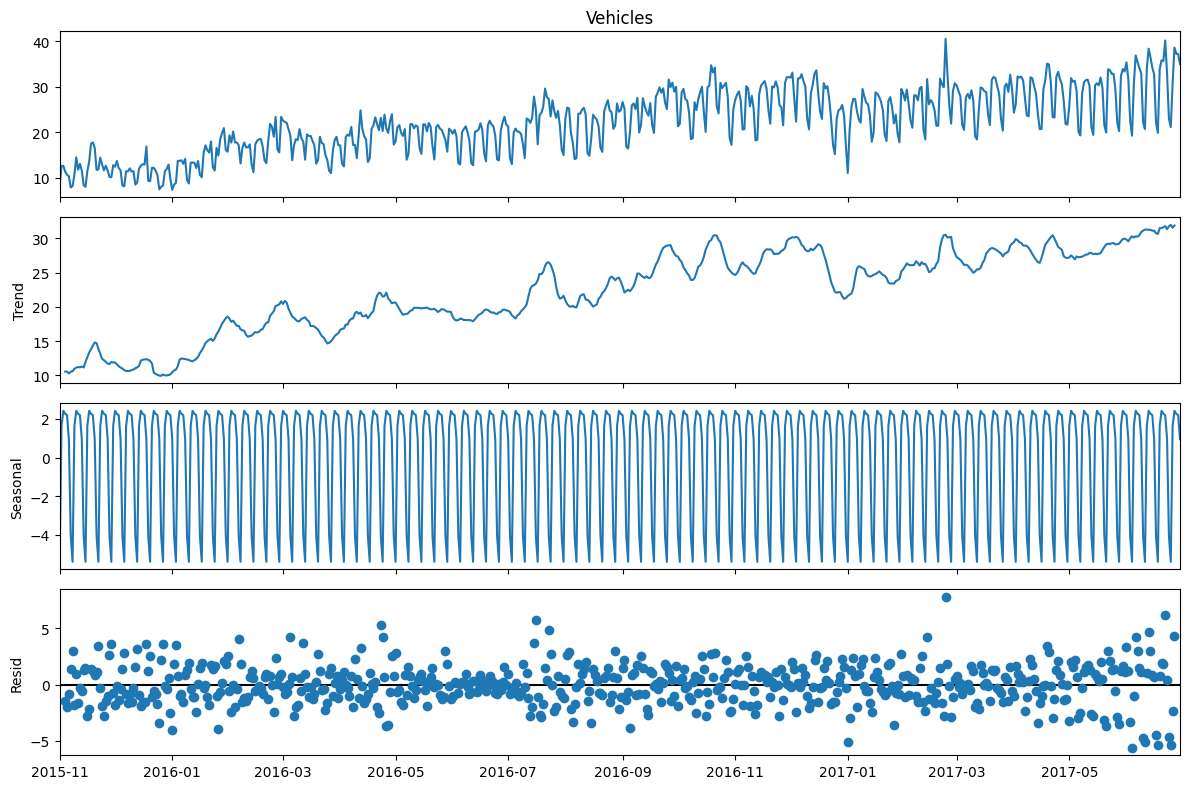

In [17]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data.set_index('DateTime', inplace=True)

# Resample the data to get daily averages
daily_traffic = traffic_data.resample('D').mean()

# Perform the seasonal decomposition
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()

In [18]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

# Convert 'DateTime' to datetime and create new time-related features
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate the correlation matrix
correlation_matrix = traffic_data[['HourOfDay', 'DayOfWeek', 'Vehicles']].corr()

print(correlation_matrix)

              HourOfDay     DayOfWeek  Vehicles
HourOfDay  1.000000e+00  6.442124e-18  0.219938
DayOfWeek  6.442124e-18  1.000000e+00 -0.126027
Vehicles   2.199377e-01 -1.260265e-01  1.000000


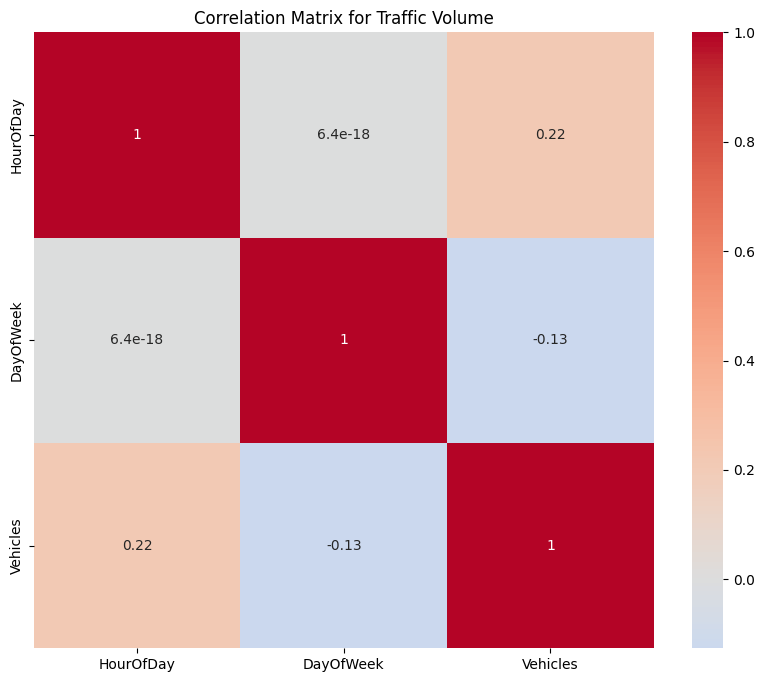

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Traffic Volume')
plt.show()

In [20]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2024-06-20 07:42:57.978972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 07:42:57.979063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 07:42:58.100822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
data=pd.read_csv("/kaggle/input/traffic-prediction-dataset/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [22]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


In [23]:
data = data[(data['Junction'] == 1)]
def Normalize(df,col):
    average = df[col].mean() #Tính giá trị trung bình của cột col trong DataFrame df.
    stdev = df[col].std()#Tính độ lệch chuẩn của cột col.
    df_normalized = (df[col] - average) / stdev #Chuẩn hóa cột col bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn.
    df_normalized = df_normalized.to_frame() #Chuyển Series df_normalized thành DataFrame.
    return df_normalized, average, stdev #rả về DataFrame đã chuẩn hóa, giá trị trung bình và độ lệch chuẩn của cột ban đầu.

def Difference(df,col, interval):
    diff = [] #Khởi tạo một danh sách rỗng để lưu trữ các giá trị khác biệt.
    for i in range(interval, len(df)): #Lặp qua các chỉ số của DataFrame từ interval đến cuối DataFrame.
        value = df[col][i] - df[col][i - interval] #Tính sự khác biệt giữa giá trị tại vị trí i và giá trị tại vị trí i - interval.
        diff.append(value) #Thêm giá trị khác biệt vào danh sách diff.
    return diff

Lọc dữ liệu:

Chỉ giữ lại các hàng có giá trị của cột 'Junction' bằng 1 trong DataFrame data.
Chuẩn hóa dữ liệu:

Hàm Normalize chuẩn hóa giá trị của một cột trong DataFrame bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn, trả về DataFrame đã chuẩn hóa cùng với giá trị trung bình và độ lệch chuẩn của cột ban đầu.
Tính sự khác biệt:

Hàm Difference tính sự khác biệt giữa các giá trị trong một cột theo khoảng thời gian interval, trả về danh sách các giá trị khác biệt.

In [24]:
df_N, av, std = Normalize(data, "Vehicles") # chuan hoa du lieu trả về ba giá trị: DataFrame chuẩn hóa (df_N), giá trị trung bình (av), và độ lệch chuẩn (std).
Diff = Difference(df_N, col="Vehicles", interval=(24*7)) #Gọi hàm Difference với DataFrame chuẩn hóa (df_N), cột "Vehicles", và khoảng thời gian (24 giờ x 7 ngày = 168 giờ).
df_N = df_N[24*7:] #Bỏ qua 168 hàng đầu tiên của DataFrame chuẩn hóa df_N.
df_N.columns = ["Norm"]
df_N["Diff"]= Diff
df = df_N["Diff"].dropna() #Loại bỏ các giá trị NaN trong cột "Diff".
df = df.to_frame()
df.head()

,Diff
168,-0.086925
169,0.130387
170,0.043462
171,0.043462
172,0.043462


Chuẩn hóa dữ liệu:

Chuẩn hóa cột "Vehicles" trong DataFrame data để có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1.
Tính sự khác biệt:

Tính sự khác biệt giữa các giá trị trong cột "Vehicles" theo khoảng thời gian một tuần (168 giờ).
Xử lý DataFrame:

Bỏ qua 168 hàng đầu tiên của DataFrame chuẩn hóa để đồng bộ với danh sách các giá trị khác biệt.
Đổi tên cột và thêm cột chứa các giá trị khác biệt vào DataFrame.
Loại bỏ các giá trị NaN và chuyển đổi Series thành DataFrame.

In [25]:
def Split_data(df):
    training_size = int(len(df)*0.80) # Lấy 80% số lượng hàng để làm kích thước tập huấn luyện 
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]  
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1) #Chuyển đổi tập huấn luyện train,test từ DataFrame sang mảng numpy và thay đổi hình dạng thành mảng có một cột
    return train, test

df_train, df_test = Split_data(df)

Chia dữ liệu:

Chia dữ liệu thành hai tập: tập huấn luyện (80% dữ liệu) và tập kiểm tra (20% dữ liệu).
Chuyển đổi dữ liệu:

Chuyển đổi dữ liệu từ DataFrame thành mảng numpy và thay đổi hình dạng thành mảng có một cột.
Trả về kết quả:

Trả về tập huấn luyện và tập kiểm tra để sử dụng trong các bước tiếp theo của quy trình phân tích hoặc huấn luyện mô hình.

In [26]:
def TnF(df):
    end_len = len(df) #Số lượng phần tử trong DataFrame df
    X = [] #Danh sách để lưu trữ các mẫu đầu vào.
    y = [] #Danh sách để lưu trữ các giá trị đích.
    steps = 32 #Số lượng bước thời gian để sử dụng cho mỗi mẫu đầu vào (ở đây là 32 bước).
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0]) #Lấy 32 giá trị trước đó làm mẫu đầu vào
        y.append(df[i, 0]) #Lấy giá trị tại vị trí hiện tại làm giá trị đích
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)
X_train, X_test = FeatureFixShape(X_train, X_test)

Tạo các mẫu đầu vào và giá trị đích:

TnF: Tạo các mẫu đầu vào và giá trị đích từ DataFrame, sử dụng 32 bước thời gian cho mỗi mẫu.
Thay đổi hình dạng dữ liệu:

FeatureFixShape: Thay đổi hình dạng dữ liệu đầu vào thành (số lượng mẫu, số bước thời gian, 1), phù hợp với định dạng đầu vào của các mô hình học sâu.

In [27]:
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The MAE is {}.".format(mae))
    return mae
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [28]:

def GRU_model(X_Train, y_Train, X_Test, y_Test):
    
    #The GRU model 
    model_GRU = Sequential() #Khởi tạo một mô hình tuần tự.
    model_GRU.add(GRU(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh')) #Thêm một lớp GRU với 100 đơn vị đầu ra, trả về chuỗi và hàm kích hoạt là tanh.
    model_GRU.add(Dropout(0.2)) #Thêm lớp dropout với tỷ lệ dropout là 0.2, giúp tránh việc quá mức phù hợp và giảm overfitting.
    model_GRU.add(GRU(units=20, input_shape=(X_Train.shape[1],1), activation='tanh')) #Thêm một lớp GRU với 20 đơn vị đầu ra, không trả về chuỗi và hàm kích hoạt là tanh
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(units=1))#Thêm một lớp dense với 1 đơn vị đầu ra.

    #Compiling the model
    model_GRU.compile(optimizer=SGD(momentum=0.9),loss='mean_squared_error') #Sử dụng trình tối ưu hóa SGD Sử dụng hàm mất mát là mean squared error (MSE).
    model_GRU.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_GRU= model_GRU.predict(X_Test)
    return pred_GRU

In [29]:
Pred_GRU = GRU_model(X_train,y_train,X_test,y_test) #huấn luyện và dự đoán của mô hình GRU trên tập dữ liệu,


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0734 - val_loss: 0.0614
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0473 - val_loss: 0.0595
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0476 - val_loss: 0.0587
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0470 - val_loss: 0.0580
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0456 - val_loss: 0.0576
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0464 - val_loss: 0.0570
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0459 - val_loss: 0.0567
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0457 - val_loss: 0.0565
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0465 - val_loss: 0.0563
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0429 - val_loss: 0.0561
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0469 - val_loss: 0.0564
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0461 - val_l

The root mean squared error is 0.23487301369396513.
The MAE is 0.16981591020848621.


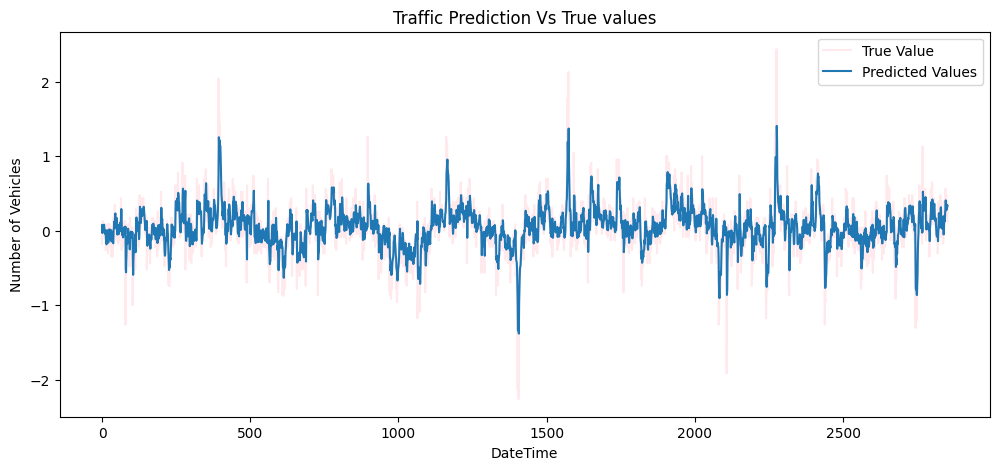

In [30]:
RMSE_GRU = RMSE_Value(y_test, Pred_GRU)
MAE_GRU = MAE_Value(y_test, Pred_GRU)
PredictionsPlot(y_test, Pred_GRU, 0)


In [31]:
def LSTM_model(X_Train, y_Train, X_Test, y_Test): 
    
    #The LSTM model 
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh')) #hêm một lớp LSTM với 100 đơn vị đầu ra, trả về chuỗi, và hàm kích hoạt là tanh.
    model_LSTM.add(Dropout(0.2)) #Thêm một lớp dropout với tỷ lệ dropout là 0.2 để giảm overfitting.
    model_LSTM.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(units=1)) # thêm một lớp dense với 1 đơn vị đầu ra.
    
    #Compiling the model
    model_LSTM.compile(optimizer=SGD(momentum=0.9),loss='mean_squared_error') #Sử dụng trình tối ưu hóa SGD Sử dụng hàm mất mát là mean squared error (MSE).
    model_LSTM.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_LSTM = model_LSTM.predict(X_Test)
    return pred_LSTM

In [32]:
Pred_LSTM = LSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0789 - val_loss: 0.0798
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0593 - val_loss: 0.0763
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0566 - val_loss: 0.0736
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0550 - val_loss: 0.0717
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0569 - val_loss: 0.0702
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0545 - val_loss: 0.0688
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0542 - val_loss: 0.0677
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0556 - val_loss: 0.0668
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0533 - val_loss: 0.0656
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0523 - val_loss: 0.0649
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0501 - val_loss: 0.0639
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0501 - val_lo

The root mean squared error is 0.23607401331702327.
The MAE is 0.17025050412573103.


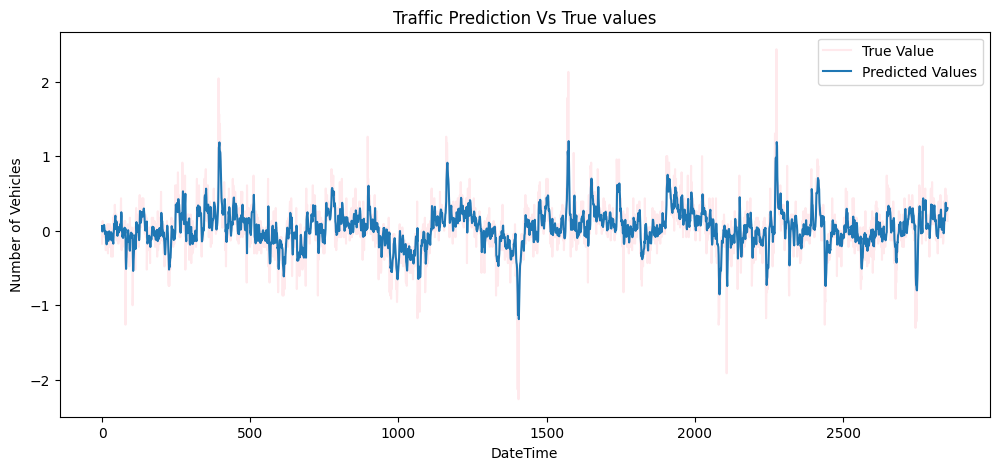

In [33]:
RMSE_LSTM = RMSE_Value(y_test, Pred_LSTM)
MAE_LSTM = MAE_Value(y_test, Pred_LSTM)
PredictionsPlot(y_test, Pred_LSTM, 0)

In [34]:
def BiLSTM_model(X_Train, y_Train, X_Test, y_Test):
    
    # The Bi-LSTM model
    model_BiLSTM = Sequential()
    model_BiLSTM.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh'), input_shape=(X_Train.shape[1], 1)))
    model_BiLSTM.add(Dropout(0.2))
    model_BiLSTM.add(Bidirectional(LSTM(units=20, activation='tanh')))
    model_BiLSTM.add(Dropout(0.2))
    model_BiLSTM.add(Dense(units=1))

    # Compiling the model
    model_BiLSTM.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')
    model_BiLSTM.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_BiLSTM = model_BiLSTM.predict(X_Test)
    return pred_BiLSTM

In [35]:
Pred_BiLSTM = BiLSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0767 - val_loss: 0.0765
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0539 - val_loss: 0.0704
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0559 - val_loss: 0.0673
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0531 - val_loss: 0.0650
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0496 - val_loss: 0.0630
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0508 - val_loss: 0.0617
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0479 - val_loss: 0.0620
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0465 - val_loss: 0.0598
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0442 - val_loss: 0.0595
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0468 - val_loss: 0.0586
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0442 - val_loss: 0.0583
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

The root mean squared error is 0.2338277562051798.
The MAE is 0.16859014454582916.


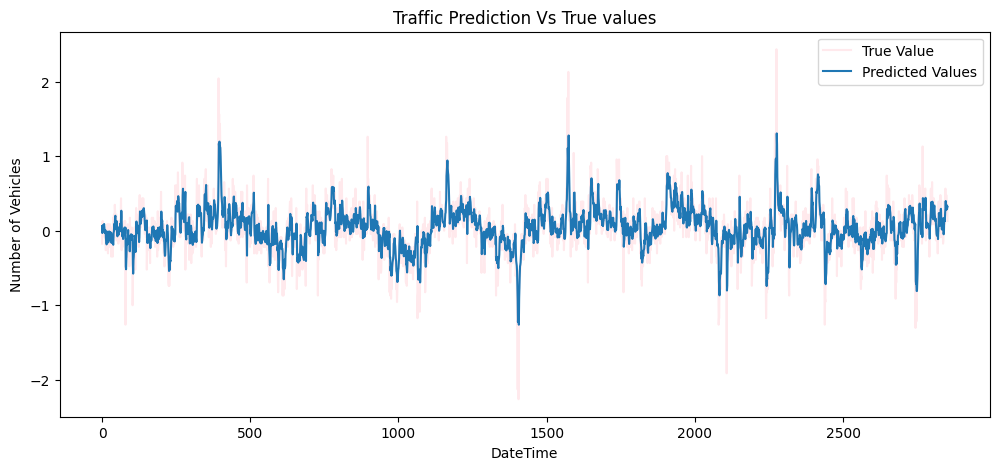

In [36]:
RMSE_BiLSTM = RMSE_Value(y_test, Pred_BiLSTM)
MAE_BiLSTM = MAE_Value(y_test, Pred_BiLSTM)
PredictionsPlot(y_test, Pred_BiLSTM, 0)

In [37]:
def LSTM_BiLSTM_model(X_Train, y_Train, X_Test, y_Test):

    # The combined LSTM, Bi-LSTM, and LSTM model
    model_LSTM_BiLSTM = Sequential()
    
    # Adding the first LSTM layer
    model_LSTM_BiLSTM.add(LSTM(units=100, return_sequences=True, activation='tanh', input_shape=(X_Train.shape[1], 1)))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Adding a Bidirectional LSTM layer
    model_LSTM_BiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='tanh')))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Adding the second LSTM layer
    model_LSTM_BiLSTM.add(LSTM(units=20, activation='tanh'))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Output layer
    model_LSTM_BiLSTM.add(Dense(units=1))

    # Compiling the model
    model_LSTM_BiLSTM.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')
    
    # Fitting the model
    model_LSTM_BiLSTM.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    
    # Making predictions
    pred_LSTM_BiLSTM = model_LSTM_BiLSTM.predict(X_Test)
    
    return pred_LSTM_BiLSTM

In [38]:
Pred_LSTM_BiLSTM = LSTM_BiLSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0794 - val_loss: 0.0907
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0672 - val_loss: 0.0860
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0663 - val_loss: 0.0840
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0619 - val_loss: 0.0799
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0629 - val_loss: 0.0775
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0597 - val_loss: 0.0757
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0570 - val_loss: 0.0757
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0565 - val_loss: 0.0722
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0527 - val_loss: 0.0705
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0533 - val_loss: 0.0690
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0536 - val_loss: 0.0676
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

The root mean squared error is 0.2384249791807007.
The MAE is 0.17203285108598124.


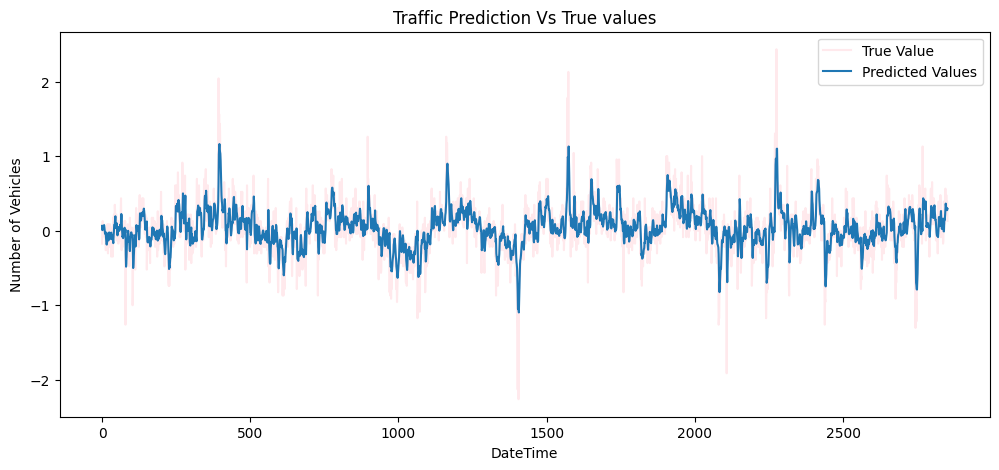

In [39]:
RMSE_LSTM_BiLSTM = RMSE_Value(y_test, Pred_LSTM_BiLSTM)
MAE_LSTM_BiLSTM = MAE_Value(y_test, Pred_LSTM_BiLSTM)
PredictionsPlot(y_test, Pred_LSTM_BiLSTM, 0)

In [40]:
# Tạo bảng so sánh các độ đo
data = {
    "Model": ["GRU", "LSTM", "BiLSTM", "LSTM + BiLSTM"],
    "RMSE": [RMSE_GRU, RMSE_LSTM, RMSE_BiLSTM, RMSE_LSTM_BiLSTM],
    "MAE": [MAE_GRU, MAE_LSTM, MAE_BiLSTM, MAE_LSTM_BiLSTM],
}

comparison_df = pd.DataFrame(data)

# Hiển thị bảng so sánh
print(comparison_df)

           Model      RMSE       MAE
0            GRU  0.234873  0.169816
1           LSTM  0.236074  0.170251
2         BiLSTM  0.233828  0.168590
3  LSTM + BiLSTM  0.238425  0.172033


Kết quả phân tích cho thấy rằng mô hình BİLSTM là mô hình hiệu quả nhất trong việc dự đoán giá trị của biến mục tiêu. Mô hình này có thể được sử dụng để dự đoán giá trị của biến mục tiêu trong các ứng dụng thực tế.

In [41]:
data=pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [42]:
feat1 = ['Vehicles']

In [43]:
feat2 = data[feat1].values

In [44]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from hmmlearn import hmm
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")



# Khởi tạo mô hình HMM
model_hmm = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)

# Huấn luyện mô hình
model_hmm.fit(feat2)

# Dự đoán trạng thái
hidden_states = model_hmm.predict(feat2)

# Lấy các giá trị dự đoán
pred_HMM = model_hmm.means_[hidden_states]
# In ra các tham số của mô hình sau khi huấn luyện
print("Start probabilities: ", model_hmm.startprob_)
print("Transition matrix: ", model_hmm.transmat_)
print("Means: ", model_hmm.means_)
print("Covariances: ", model_hmm.covars_)


Start probabilities:  [2.08885184e-061 7.71469678e-234 1.00000000e+000]
Transition matrix:  [[9.20801896e-01 2.94448213e-02 4.97532830e-02]
 [3.64794043e-02 9.63355392e-01 1.65203381e-04]
 [3.97458573e-02 8.94838361e-05 9.60164659e-01]]
Means:  [[18.52807838]
 [51.156262  ]
 [ 7.94430004]]
Covariances:  [[[ 23.53686111]]

 [[420.34794197]]

 [[  9.25158148]]]


In [45]:
# Dự đoán trạng thái ẩn cho các quan sát hiện có
hidden_states = model_hmm.predict(feat2)
print("Hidden states: ", hidden_states)

# Lấy mẫu mới từ mô hình đã huấn luyện
X, Z = model_hmm.sample(5)  # Lấy mẫu 5 quan sát mới
print("Sampled observations: ", X)
print("Sampled hidden states: ", Z)

Hidden states:  [2 2 2 ... 0 0 0]
Sampled observations:  [[12.4951265 ]
 [10.09897193]
 [ 8.55379178]
 [ 8.39245357]
 [ 5.08508215]]
Sampled hidden states:  [2 2 2 2 2]


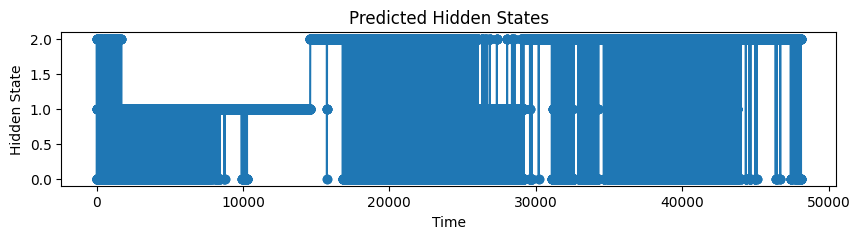

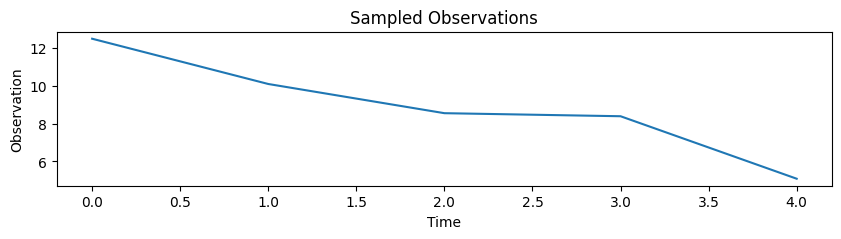

The root mean squared error is 10.955600639820588.
The MAE is 6.574413073052023.


In [46]:
# Vẽ các trạng thái ẩn dự đoán
def plot_hidden_states(hidden_states, title):
    plt.figure(figsize=(10, 2))
    plt.plot(hidden_states, marker='o')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Hidden State")
    plt.show()

plot_hidden_states(hidden_states, "Predicted Hidden States")

# Vẽ các quan sát mẫu
def plot_observations(observations, title):
    plt.figure(figsize=(10, 2)) 
    plt.plot(observations)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Observation")
    plt.show()

plot_observations(X, "Sampled Observations")
# Tính RMSE và MAE cho mô hình HMM
rmse_hmm = RMSE_Value(feat2.flatten(), pred_HMM.flatten())
mae_hmm = MAE_Value(feat2.flatten(), pred_HMM.flatten())

In [47]:
pip install filterpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=15faf3ed4a79ac6fa9e07073ad311279817c146480ae023a28ffa01ca6de4650
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
Note: you may need to restart the kernel to use updated packages.


In [48]:

# from scipy.signal import KalmanFilter
from filterpy.kalman import KalmanFilter

observations = data[feat1].values

kf = KalmanFilter(dim_x=observations.shape[1], dim_z=observations.shape[1])

# Thiết lập các giá trị khởi tạo cho Kalman Filter
kf.x = np.mean(observations, axis=0)  # Giá trị khởi tạo của trạng thái
kf.P = np.eye(observations.shape[1])  # Ma trận hiệp phương sai khởi tạo
kf.F = np.eye(observations.shape[1])  # Ma trận trạng thái chuyển tiếp
kf.H = np.eye(observations.shape[1])  # Ma trận đo lường
kf.R = np.eye(observations.shape[1])  # Ma trận nhiễu đo lường
kf.Q = np.eye(observations.shape[1])  # Ma trận nhiễu quá trình

# Lọc dữ liệu
state_means, state_covariances, _, _ = kf.batch_filter(observations)

# Debugging information
print("Shape of observations:", observations.shape)
print("State means:", state_means)
print("State covariances:", state_covariances)




Shape of observations: (48120, 1)
State means: [[17.59711139]
 [14.72391677]
 [11.79958734]
 ...
 [18.87796533]
 [20.80748887]
 [15.36416139]]
State covariances: [[[0.66666667]]

 [[0.625     ]]

 [[0.61904762]]

 ...

 [[0.61803399]]

 [[0.61803399]]

 [[0.61803399]]]


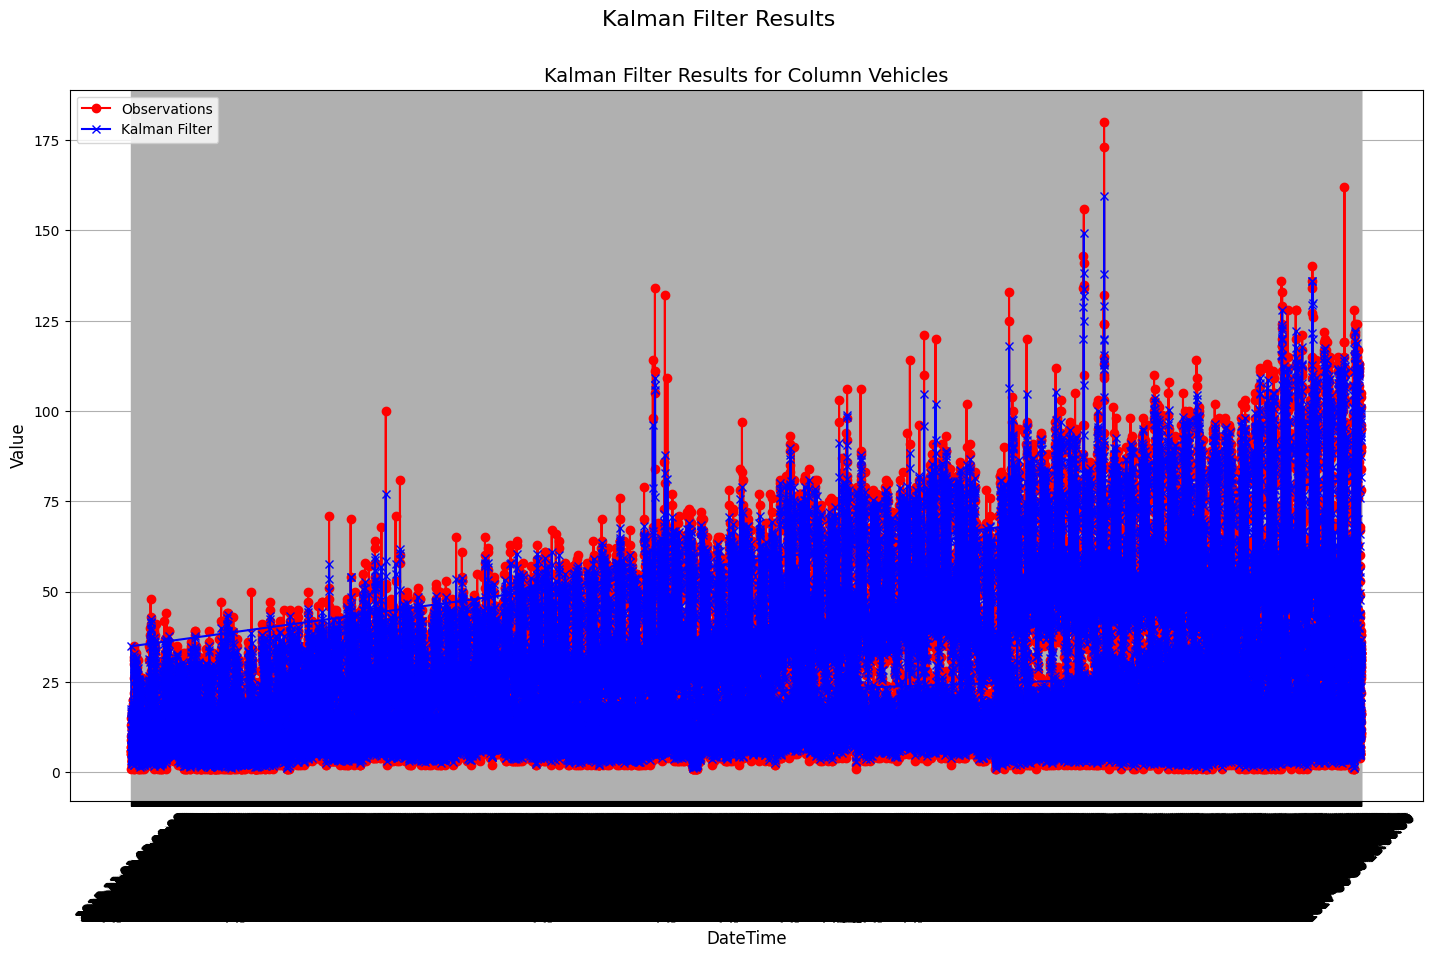

The root mean squared error is 2.1627663255500273.
The MAE is 1.3825095247396262.


In [49]:
# Plot the results for each column
plt.figure(figsize=(15, 10))

for i, col in enumerate(feat1):
    plt.subplot(len(feat1), 1, i+1)
    plt.plot(data['DateTime'], observations[:, i], 'r', label='Observations', linestyle='-', marker='o')
    plt.plot(data['DateTime'], state_means[:, i], 'b', label='Kalman Filter', linestyle='-', marker='x')
    plt.title(f'Kalman Filter Results for Column {col}', fontsize=14)
    plt.xlabel('DateTime', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

# Show the plot
plt.suptitle('Kalman Filter Results', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()
rmse_kalman = RMSE_Value(observations.flatten(), state_means.flatten())
mae_kalman = MAE_Value(observations.flatten(), state_means.flatten())

In [50]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


The root mean squared error is 27.03811291850219.
The MAE is 21.387336824892305.


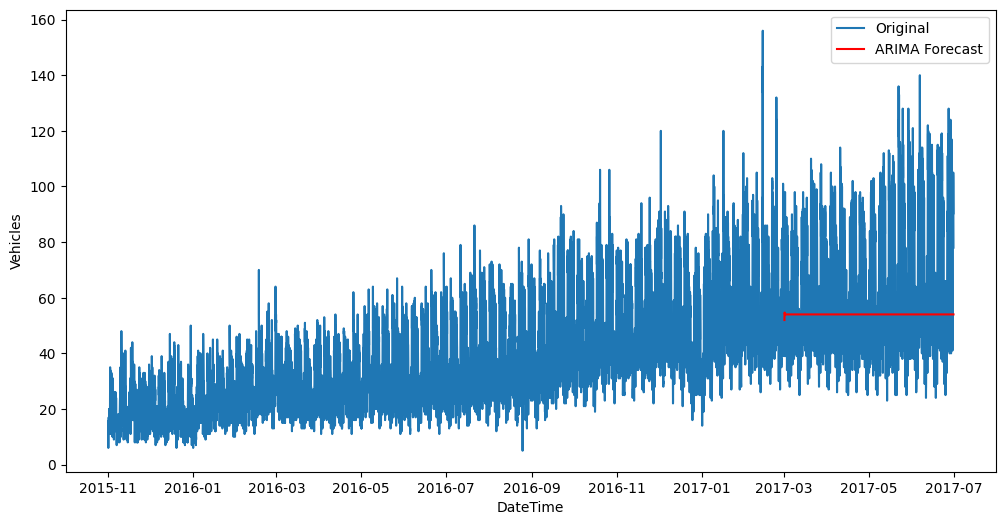

In [51]:
from statsmodels.tsa.arima.model import ARIMA
# Chuyển đổi cột DateTime sang kiểu dữ liệu datetime
data['DateTime'] = pd.to_datetime(data['DateTime'])
# Chọn dữ liệu của một ngã tư cụ thể, ví dụ Junction 1
junction_data = data[data['Junction'] == 1]

# Đặt DateTime làm chỉ mục
junction_data.set_index('DateTime', inplace=True)

# Chọn cột 'Vehicles' để xây dựng mô hình ARIMA
vehicles = junction_data['Vehicles']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(vehicles) * 0.8)
train, test = vehicles[:train_size], vehicles[train_size:]

# Xây dựng mô hình ARIMA
arima_order = (5, 1, 0)
model_arima = ARIMA(train, order=arima_order)
model_arima_fit = model_arima.fit()

# Dự đoán
forecast_arima = model_arima_fit.forecast(steps=len(test))
forecast_arima = pd.Series(forecast_arima, index=test.index)

# Tính RMSE và MAE cho mô hình ARIMA
rmse_arima = RMSE_Value(test, forecast_arima)
mae_arima = MAE_Value(test, forecast_arima)
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(vehicles, label='Original')
plt.plot(forecast_arima, label='ARIMA Forecast', color='red')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0105
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.6947e-04
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.3738e-04
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.0085e-04
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.6588e-04
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.3912e-04
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.4292e-04
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.7663e-04
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.9661e-04
Epoch 13/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.6101e-04
Epoch 14/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.1208e-04
Epoch 15/20
363/3

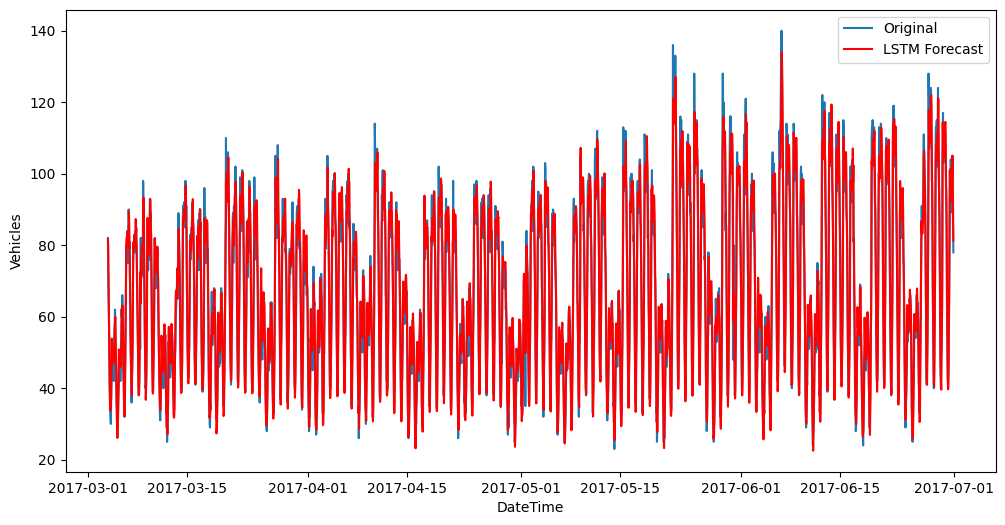

In [52]:
# Chọn cột 'Vehicles' để xây dựng mô hình LSTM
vehicles = junction_data['Vehicles'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vehicles = scaler.fit_transform(vehicles)

# Tạo tập dữ liệu huấn luyện và kiểm tra
train_size = int(len(scaled_vehicles) * 0.8)
train, test = scaled_vehicles[:train_size], scaled_vehicles[train_size:]

# Tạo dữ liệu theo các bước thời gian (time steps)
time_step = 60
X_train, y_train = [], []
for i in range(time_step, len(train)):
    X_train.append(train[i-time_step:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test = [], []
for i in range(time_step, len(test)):
    X_test.append(test[i-time_step:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Xây dựng mô hình LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình LSTM
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Dự báo với mô hình LSTM
predicted_lstm = lstm_model.predict(X_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính RMSE và MAE cho mô hình LSTM
rmse_lstm = RMSE_Value(y_test, predicted_lstm)
mae_lstm = MAE_Value(y_test, predicted_lstm)


# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(junction_data.index[-len(y_test):], y_test, label='Original')
plt.plot(junction_data.index[-len(predicted_lstm):], predicted_lstm, label='LSTM Forecast', color='red')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# Bước 1: Tính trung bình trượt (Moving Average)
window_size = 12
junction_data['MA'] = junction_data['Vehicles'].rolling(window=window_size).mean()

# Loại bỏ các giá trị NaN do trung bình trượt tạo ra
junction_data.dropna(inplace=True)


In [54]:
junction_data.head()

,Junction,Vehicles,ID,MA
DateTime,,,,
2015-11-01 11:00:00,1,17,20151101111,11.000000
2015-11-01 12:00:00,1,16,20151101121,11.083333
2015-11-01 13:00:00,1,15,20151101131,11.250000
2015-11-01 14:00:00,1,16,20151101141,11.750000
2015-11-01 15:00:00,1,12,20151101151,12.166667


In [55]:
# Bước 2: Sử dụng ARIMA để dự báo phần dư sau khi áp dụng trung bình trượt
residuals_arima = junction_data['Vehicles'] - junction_data['MA']
arima_order = (5, 1, 0)
arima_model = ARIMA(residuals_arima, order=arima_order)
arima_result = arima_model.fit()

# Dự báo phần dư bằng ARIMA
forecast_arima_residuals = arima_result.predict(start=0, end=len(junction_data)-1)
combined_residuals = residuals_arima - forecast_arima_residuals



In [56]:
print(forecast_arima_residuals)
print(combined_residuals)

2015-11-01 11:00:00     0.000000
2015-11-01 12:00:00     6.000072
2015-11-01 13:00:00     4.588693
2015-11-01 14:00:00     3.302819
2015-11-01 15:00:00     4.170552
                         ...    
2017-06-30 19:00:00     4.594387
2017-06-30 20:00:00    15.107235
2017-06-30 21:00:00     0.089548
2017-06-30 22:00:00    -7.744871
2017-06-30 23:00:00   -14.757730
Freq: h, Name: predicted_mean, Length: 14581, dtype: float64
DateTime
2015-11-01 11:00:00     6.000000
2015-11-01 12:00:00    -1.083406
2015-11-01 13:00:00    -0.838693
2015-11-01 14:00:00     0.947181
2015-11-01 15:00:00    -4.337219
                         ...    
2017-06-30 19:00:00     9.405613
2017-06-30 20:00:00   -13.357235
2017-06-30 21:00:00    -6.172882
2017-06-30 22:00:00    -4.005129
2017-06-30 23:00:00    -1.075603
Length: 14581, dtype: float64


In [57]:
# Bước 3: Sử dụng LSTM để dự báo phần dư sau khi áp dụng ARIMA
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_residuals = scaler.fit_transform(combined_residuals.values.reshape(-1, 1))

# Tạo tập dữ liệu cho LSTM
time_step = 60
X_train, y_train = [], []
for i in range(time_step, len(scaled_combined_residuals)):
    X_train.append(scaled_combined_residuals[i-time_step:i, 0])
    y_train.append(scaled_combined_residuals[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [58]:
# Xây dựng mô hình LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình LSTM
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Dự báo phần dư bằng LSTM
test_data = scaled_combined_residuals[-time_step:]
X_test = []
for i in range(time_step, len(scaled_combined_residuals)):
    X_test.append(scaled_combined_residuals[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

predicted_residuals = lstm_model.predict(X_test)
predicted_residuals = scaler.inverse_transform(predicted_residuals)

# Kết hợp các dự báo
final_forecast = junction_data['MA'].values[-len(predicted_residuals):] + forecast_arima_residuals.values[-len(predicted_residuals):] + predicted_residuals.flatten()

# Kiểm tra kích thước dữ liệu dự báo
print("Length of original data:", len(junction_data))
print("Length of final forecast:", len(final_forecast))

Epoch 1/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0100
Epoch 2/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0031
Epoch 3/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0030
Epoch 4/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0029
Epoch 5/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0026
Epoch 6/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0025
Epoch 7/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0025
Epoch 8/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0025
Epoch 9/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022
Epoch 10/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021
Epoch 11/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0020
Epoch 12/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021
Epoch 13/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019
Epoch 14/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0019
Epoch 15/20
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lo

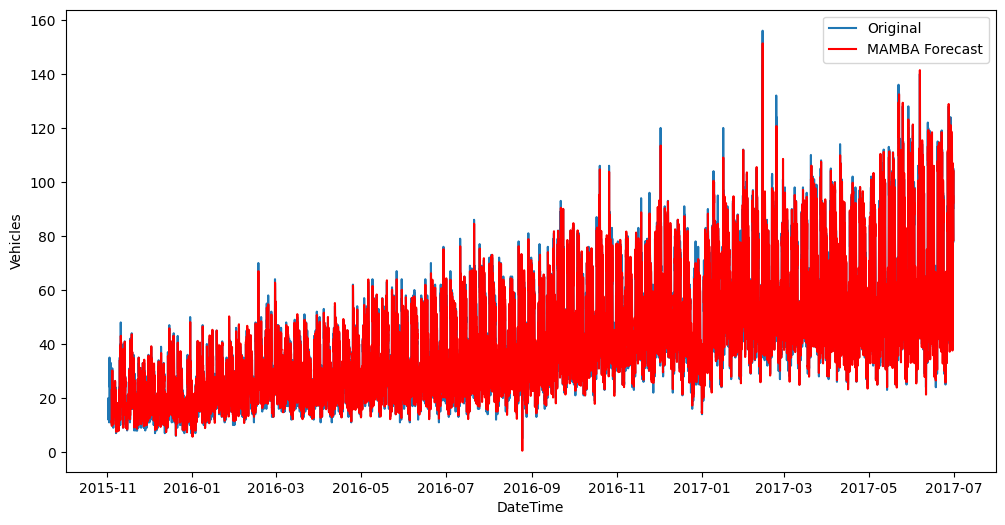

The root mean squared error is 4.581449269527754.
The MAE is 3.3358273682482924.


In [59]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(junction_data.index, junction_data['Vehicles'], label='Original')
plt.plot(junction_data.index[-len(final_forecast):], final_forecast, label='MAMBA Forecast', color='red')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()
plt.show()
# Tính RMSE và MAE
actual_values = junction_data['Vehicles'].values[-len(final_forecast):]
rmse_mamba = RMSE_Value(actual_values, final_forecast)
mae_mamba = MAE_Value(actual_values, final_forecast)

In [60]:
# Tạo bảng so sánh các độ đo
data = {
    "Model": ["HMM","KALMAN", "ARIMA" ,"LSTM","MAMBA"],
    "RMSE": [rmse_hmm,rmse_kalman,rmse_arima,rmse_lstm,rmse_mamba],
    "MAE": [mae_hmm,mae_kalman,mae_arima,mae_lstm,mae_mamba],
}

comparison_df = pd.DataFrame(data)

# Hiển thị bảng so sánh
print(comparison_df)

    Model       RMSE        MAE
0     HMM  10.955601   6.574413
1  KALMAN   2.162766   1.382510
2   ARIMA  27.038113  21.387337
3    LSTM   5.348917   3.931029
4   MAMBA   4.581449   3.335827
